In [34]:
import os
import random
from abc import abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F1
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, transforms
from tqdm import tqdm
from types_ import *
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim_skimage

In [35]:
import shutil

# Удаляем .ipynb_checkpoints
checkpoints_dir = "/home/jupyter/datasphere/filestore/fulltiles/images/.ipynb_checkpoints"
if os.path.exists(checkpoints_dir):
    shutil.rmtree(checkpoints_dir)

# Дополнительно: удаляем другие временные файлы
for root, dirs, files in os.walk("/home/jupyter/datasphere/filestore/fulltiles"):
    for file in files:
        if file.endswith("~") or file == ".DS_Store":  # Примеры временных файлов
            os.remove(os.path.join(root, file))

In [36]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [37]:
class PairedTopoDataset(Dataset):
    def __init__(self, image_dir, topo_dir, transform):
        """
        Args:
            image_dir (str): Папка с обычными изображениями (без `_topo`).
            topo_dir (str): Папка с топо-изображениями (с `_topo`).
            transform (callable, optional): Дополнительные аугментации.
        """
        self.image_dir = image_dir
        self.topo_dir = topo_dir
        self.transform = transform
        self.to_tensor = ToTensor()  # Конвертирует PIL → Tensor и нормализует в [0, 1]

        # Собираем все файлы и находим пары (image, topo)
        self.pairs = self._find_paired_files()

    def _extract_base(self, filename):
        """Извлекает базовое имя и номер из названия файла.
        Пример:
            "cor_000_Pomona_..._0.png" → ("cor_000_Pomona_...", 0)
            "cor_000_Pomona_..._topo_5.png" → ("cor_000_Pomona_...", 5)
        """
        # Удаляем расширение (.png, .jpg и т.д.)
        base_part = os.path.splitext(filename)[0]

        # Если в названии есть `_topo`, убираем его из базовой части
        if "_topo" in base_part:
            base_part = base_part.replace("_topo", "")

        return base_part

    def _find_paired_files(self):
        """Находит все пары (image, topo) с одинаковыми base_name и номером."""
        # Собираем все файлы из image_dir и topo_dir
        image_files = os.listdir(self.image_dir)
        topo_files = os.listdir(self.topo_dir)

        # Создаем словарь: { (base_name, number) → {"image": path, "topo": path} }
        pairs_dict = {}

        # Обрабатываем обычные изображения (без `_topo`)
        for img_file in image_files:
            base = self._extract_base(img_file)
            if base is None:
                continue  # Пропускаем файлы с неправильным форматом
            key = base
            if key not in pairs_dict:
                pairs_dict[key] = {"image": None, "topo": None}
            pairs_dict[key]["image"] = os.path.join(self.image_dir, img_file)

        # Обрабатываем топо-изображения (с `_topo`)
        for topo_file in topo_files:
            base = self._extract_base(topo_file)
            if base is None:
                continue
            key = base
            if key not in pairs_dict:
                continue  # Нет пары в image_dir → пропускаем
            pairs_dict[key]["topo"] = os.path.join(self.topo_dir, topo_file)

        # Оставляем только полные пары (где есть и image, и topo)
        valid_pairs = []
        for key in pairs_dict:
            if pairs_dict[key]["image"] and pairs_dict[key]["topo"]:
                img_name = os.path.basename(pairs_dict[key]["image"])
                topo_name = os.path.basename(pairs_dict[key]["topo"])
                valid_pairs.append(
                    (
                        pairs_dict[key]["image"],  # путь к обычному изображению
                        pairs_dict[key]["topo"],  # путь к топо-изображению
                        img_name,  # имя файла обычного изображения
                        topo_name,  # имя файла топо-изображения
                    )
                )
        return valid_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, topo_path, img_name, topo_name = self.pairs[idx]
    
    # Загружаем изображения
        img = Image.open(img_path).convert("L")
        topo = Image.open(topo_path).convert("L")

        # Конвертируем в numpy и нормализуем
        img = np.array(img).astype(np.float32) / 255
        topo = np.array(topo).astype(np.float32) / 255

        # Преобразуем в тензоры [1, H, W]
        img_tensor = self.to_tensor(img)
        topo_tensor = self.to_tensor(topo)
        
        # Применяем аугментации
        if self.transform:
            img_tensor = self.transform(img_tensor)
            topo_tensor = self.transform(topo_tensor)

        return img_tensor, img_name

In [38]:
class VanillaVAE(BaseVAE):

    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim
            # in_channels = 2

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16 * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # print(f"Encoder output shape: {result.shape}")
        result = torch.flatten(result, start_dim=1)
        # print(f"Flattened shape: {result.shape}")

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 16, 16)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        def mssim_loss(recons, target):
            return 1 - ms_ssim(recons, target, data_range=1.0, size_average=True)

        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        log_var = torch.clamp(log_var, min=-10, max=10)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )
        kld_weight = 0.0001

        recons_loss = F.mse_loss(recons, input[:,0,:,:].unsqueeze(1))
        # recons_loss = F.mse_loss(recons, input[:,0,:,:])
        recons_weight = 0.8
        
        mssim = mssim_loss(recons, input[:, 0, :, :].unsqueeze(1))
        # mssim = mssim_loss(recons, input[:, 0, :, :])
        mssim_weight = 1 - recons_weight

        loss = recons_loss * recons_weight + kld_loss * kld_weight + mssim * mssim_weight
        
        # loss = recons_loss * recons_weight
        return {"loss": loss, "Reconstruction_Loss": recons_loss, "KLD": kld_loss, "MSSIM": mssim}
        # return {"loss": loss, "Reconstruction_Loss": recons_loss}

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [39]:
# Определим аугментации
class Random90Rotation:
    """Случайный поворот на угол, кратный 90 градусам (0, 90, 180, 270)"""

    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        return F1.rotate(img, angle)


augmentations = transforms.Compose(
    [
        Random90Rotation(),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
    ],
)

In [40]:
image_dir=r"/home/jupyter/datasphere/filestore/fulltiles/images"  # папка с обычными изображениями
topo_dir=r"/home/jupyter/datasphere/filestore/fulltiles/topo"  # папка с топо-изображениями
    
dataset = PairedTopoDataset(
    image_dir,
    topo_dir,
    transform = None,
)

In [41]:
print(f"Найдено пар: {len(dataset)}")
img_tensor, name = dataset[0]
print(f"Размер тензора: {img_tensor.shape}, имя: {name}")

Найдено пар: 688
Размер тензора: torch.Size([1, 3839, 4096]), имя: cor_000_Pomona_437x282km_79.3_-60.6_466.0km.tif


In [42]:
# Выбираем первое изображение из датасета
sample, img_name = dataset[0]  # Или sample = dataset[0][0] если возвращается (img, name)

# Размерность изображения
print(f"Размерность изображения: {sample.shape}")
print(f"Тип данных: {sample.dtype}")
print(f"Имя файла: {img_name}")

Размерность изображения: torch.Size([1, 3839, 4096])
Тип данных: torch.float32
Имя файла: cor_000_Pomona_437x282km_79.3_-60.6_466.0km.tif


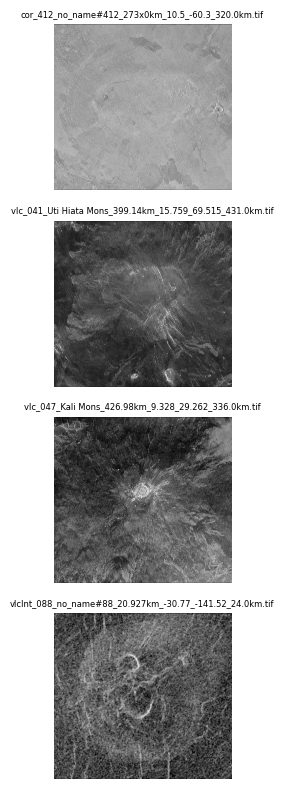

In [43]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, num_workers=4
)

batch, img_names = next(iter(dataloader))

plt.figure(figsize=(12, 8))
for i in range(4):
    # Берем i-й пример из батча
    img_pair = batch[i]

    # Разделяем каналы
    img = img_pair[0].numpy().squeeze()
    # print(img.shape)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{img_names[i]}", fontsize=6)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaVAE(in_channels=1, latent_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 102

In [45]:
# Загрузка весов
weights_path = '/home/jupyter/datasphere/project/vanilla_vae_weights120.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [46]:
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])
torch.Size([1, 1, 3839, 4096])


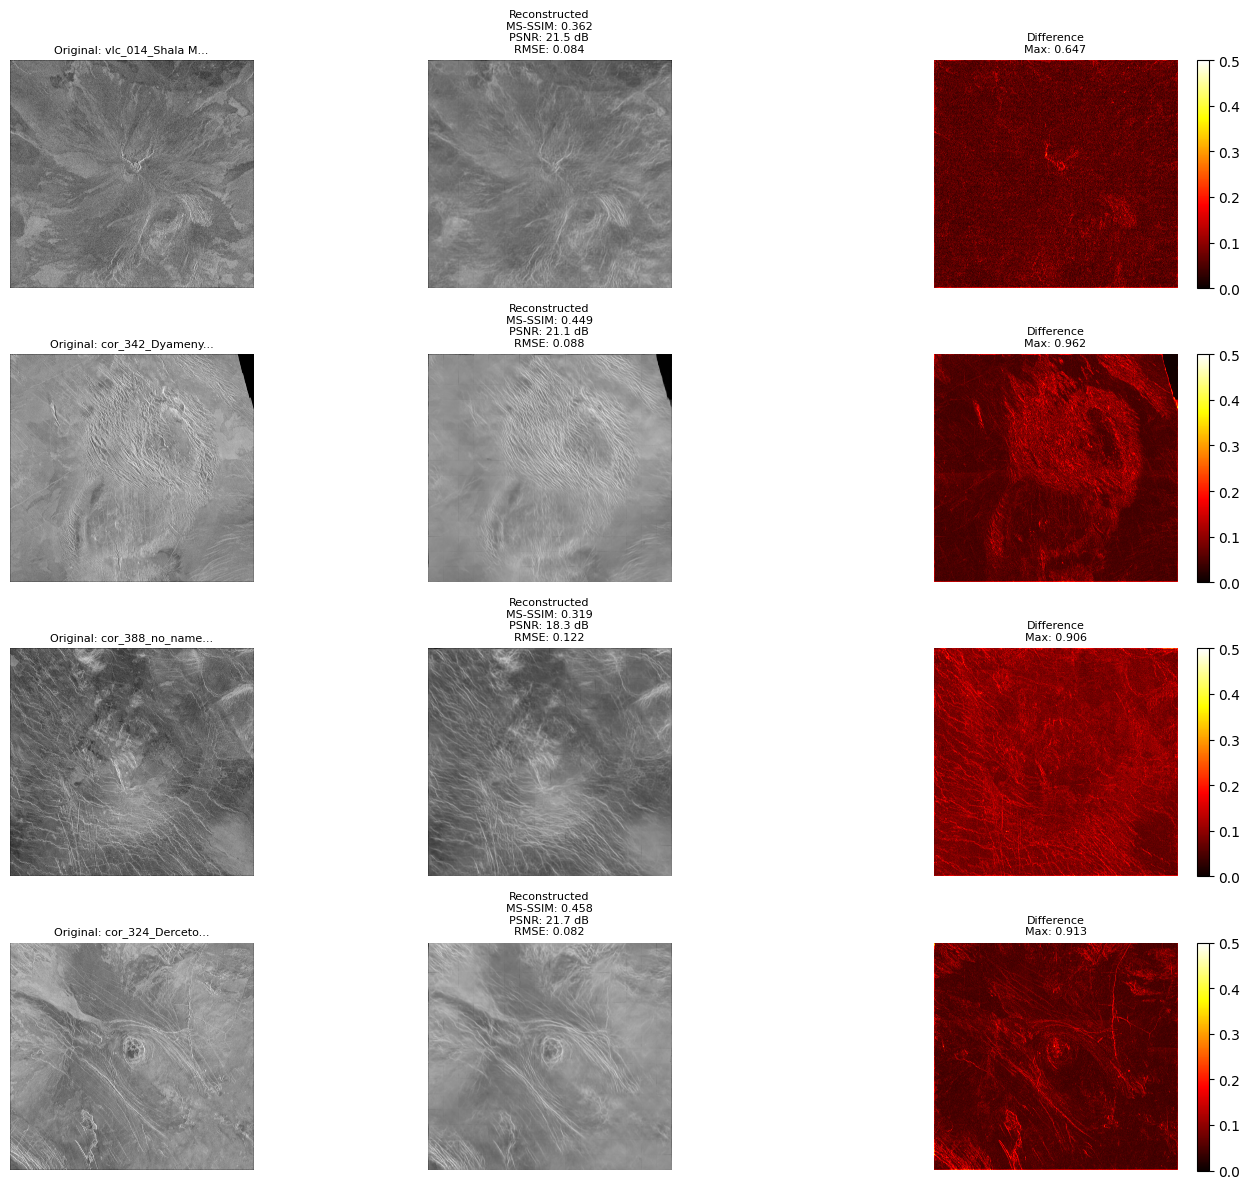


Средние метрики по 4 изображениям:
MS-SSIM: 0.3967
PSNR: 20.66
RMSE: 0.0939
Max difference: 0.8569


In [60]:
from pytorch_msssim import ms_ssim  # Добавляем импорт для MS-SSIM

def calculate_rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))

def process_large_image_with_overlap(model, large_img, tile_size=512, overlap=256, device='cuda'):
    """
    Обрабатывает большое изображение тайлами с перекрытием
    tile_size: размер тайла (рекомендуется 256-512 для больших изображений)
    overlap: рекомендуемое значение - половина tile_size
    """
    # Проверяем размерности
    if len(large_img.shape) == 2:
        large_img = large_img.unsqueeze(0).unsqueeze(0)
    elif len(large_img.shape) == 3:
        large_img = large_img.unsqueeze(0)
    
    h, w = large_img.shape[-2:]
    stride = tile_size - overlap
    
    # Добавляем паддинг
    pad_h = (tile_size - h % stride) if h % stride != 0 else 0
    pad_w = (tile_size - w % stride) if w % stride != 0 else 0
    
    if pad_h > 0 or pad_w > 0:
        large_img = F.pad(large_img, (0, pad_w, 0, pad_h), mode='reflect')
    
    # Создаем гауссову маску для плавного смешивания
    y, x = torch.meshgrid(torch.linspace(-1, 1, tile_size),
                      torch.linspace(-1, 1, tile_size),
                      indexing='ij')
    mask = torch.exp(-(x**2 + y**2))
    mask = mask.to(device)
    
    # Инициализируем результат
    result = torch.zeros_like(large_img, device=device)
    count = torch.zeros_like(large_img, device=device)
    
    # Обрабатываем тайлы
    for y in range(0, h + pad_h - tile_size + 1, stride):
        for x in range(0, w + pad_w - tile_size + 1, stride):
            tile = large_img[..., y:y+tile_size, x:x+tile_size].to(device)
            
            with torch.no_grad():
                recon_tile = model(tile)[0].clamp(0, 1)  # Ограничиваем диапазон
            
            result[..., y:y+tile_size, x:x+tile_size] += recon_tile * mask
            count[..., y:y+tile_size, x:x+tile_size] += mask
    
    # Нормализуем и обрезаем паддинг
    result = (result / count)[..., :h, :w]
    
    return result.squeeze().cpu()

with torch.no_grad():
    num_images = 4
    plt.figure(figsize=(14, 3 * num_images))
    
    msssim_values = []
    psnr_values = []
    rmse_values = []
    max_diff_values = []
    
    random_indices = random.sample(range(len(dataset)), num_images)
    
    for i in range(num_images):
        idx = random_indices[i]
        x, img_name = dataset[idx]
        x = x.unsqueeze(0)  # [1, 1, H, W]
        # Обрабатываем большое изображение тайлами
        reconstructed = process_large_image_with_overlap(model, x, tile_size=512, device=device)
        
        # Приводим к правильной размерности
        original_4d = x.cpu()  # [1, 1, H, W]
        reconstructed_4d = reconstructed.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

        # Проверяем размерности
        if original_4d.shape != reconstructed_4d.shape:
            # Если размерности не совпадают, делаем crop до минимальных размеров
            min_h = min(original_4d.shape[2], reconstructed_4d.shape[2])
            min_w = min(original_4d.shape[3], reconstructed_4d.shape[3])
            original_4d = original_4d[:, :, :min_h, :min_w]
            reconstructed_4d = reconstructed_4d[:, :, :min_h, :min_w]
        
        # Для других метрик используем numpy массивы
        original_np = original_4d.squeeze().numpy()  # [H, W]
        reconstructed_np = reconstructed_4d.squeeze().numpy()  # [H, W]
        
        # Вычисляем метрики
        try:
            # MS-SSIM (требует [B, C, H, W])
            msssim_val = ms_ssim(original_4d, reconstructed_4d, data_range=1.0, size_average=True)
            msssim_val = float(msssim_val.item())
            
            # PSNR и RMSE
            psnr_val = psnr(original_np, reconstructed_np, data_range=1.0)
            rmse_val = calculate_rmse(original_np, reconstructed_np)
            
        except Exception as e:
            print(f"Error calculating metrics for {img_name}: {str(e)}")
            msssim_val, psnr_val, rmse_val = -1.0, -1.0, -1.0
        
        # Сохраняем метрики
        msssim_values.append(msssim_val)
        psnr_values.append(psnr_val)
        rmse_values.append(rmse_val)
        
        # Визуализация
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(original_np, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Original: {img_name[:15]}...", fontsize=8)
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(reconstructed_np, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Reconstructed\nMS-SSIM: {msssim_val:.3f}\nPSNR: {psnr_val:.1f} dB\nRMSE: {rmse_val:.3f}", 
                fontsize=8)
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3*i + 3)
        difference = np.abs(original_np - reconstructed_np)
        plt.imshow(difference, cmap='hot', vmin=0, vmax=0.5)
        plt.title(f"Difference\nMax: {difference.max():.3f}", fontsize=8)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        max_diff_values.append(difference.max())
    
    plt.tight_layout()
    plt.savefig('large_reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Вывод средних метрик
    print(f"\nСредние метрики по {num_images} изображениям:")
    print(f"MS-SSIM: {np.mean(msssim_values):.4f}")
    print(f"PSNR: {np.mean(psnr_values):.2f}")
    print(f"RMSE: {np.mean(rmse_values):.4f}")
    print(f"Max difference: {np.mean(max_diff_values):.4f}")